In [25]:
# https://github.com/mikexcohen/DeepUnderstandingOfDeepLearning/blob/main/regularization/DUDL_regular_dropout.ipynb

import torch

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


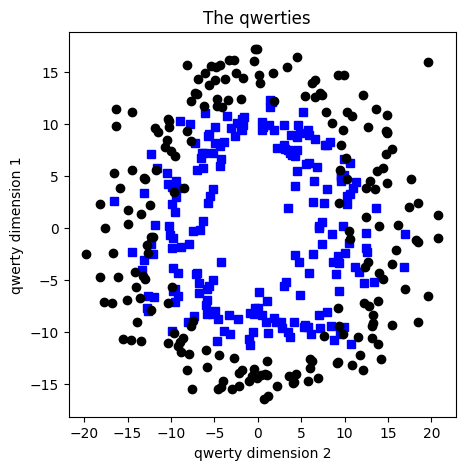

In [26]:

nPerClust = 200

th = np.linspace(0, 4*np.pi, nPerClust)

r1 = 10
r2 = 15
a = [r1 * np.cos(th)+np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)
     ]

b = [r2 * np.cos(th)+np.random.randn(nPerClust)*3,
     r2*np.sin(th) + np.random.randn(nPerClust)
     ]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
data_np = np.hstack((a,b)).T
 
 
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels ==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels ==1)[0],0],data[np.where(labels==1)[0],1],'ko')

plt.title('The qwerties  ')
plt.ylabel('qwerty dimension 1')
plt.xlabel('qwerty dimension 2')

plt.show()



In [27]:

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)
train_data= TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)
batchsize =16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [28]:

class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        
        super().__init__()
        
        ### layers
        self.input = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128,1)

        self.dr = dropoutRate
    
    def forward(self,x):
        
        x = F.relu(self.input(x))

        # 在输入层之后 dropout
        x = F.dropout(x,p=self.dr,training=self.training)

        x =F.relu(self.hidden(x))
        # 在隐藏层之后dropout
        x = F.dropout(x,p=self.dr,training=self.training)
        
        x = self.output(x)

        return x


In [29]:
# test the model

tmpnet = theModelClass(.25)

tmpdata = torch.randn((10,2))

yhat = tmpnet(tmpdata)
yhat

tensor([[-0.0904],
        [-0.1483],
        [-0.1058],
        [ 0.1272],
        [-0.1609],
        [ 0.1932],
        [ 0.0531],
        [ 0.1643],
        [ 0.0193],
        [ 0.0218]], grad_fn=<AddmmBackward0>)

In [30]:

def createModel(dropoutrate):
    
    ANNQC = theModelClass(dropoutrate)

    lossfun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.SGD(ANNQC.parameters(),lr= .002)

    return ANNQC,lossfun,optimizer
    

In [31]:
# train the model

numepochs = 1000


def trainTheModel(ANNQC, lossfun, optimizer):

    trainAcc = []
    testAcc = []
    ANNQC.train()

    for epochi in range(numepochs):

        batchAcc = []

        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNQC(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean(((yHat > .5) == y).float()).item())

        trainAcc.append(np.mean(batchAcc))

        ANNQC.eval()
        X, y = next(iter(test_loader))
        yHat = ANNQC(X)
        testAcc.append(100*torch.mean(((yHat > .5) == y).float()).item())

    return trainAcc, testAcc

In [32]:


# 丢弃比例,  0 代表不丢弃
dropoutrate = .0

ANNQC,lossfun,optimizer = createModel(dropoutrate)

trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

In [39]:

def smooth(x,k=20):
    return np.convolve(x,np.ones(k)/k,mode='same')

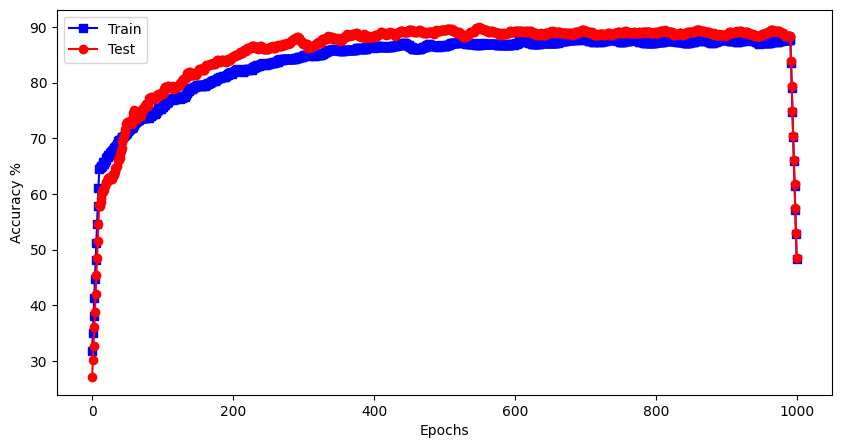

In [40]:
fig = plt.figure(figsize=(10,5))
# plt.plot(trainAcc,'bs-')
# plt.plot(testAcc,'ro-')
plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')

plt.xlabel('Epochs')
plt.ylabel('Accuracy %')

plt.legend(['Train','Test'])
plt.show()

In [42]:

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNQC,lossfun,optimizer = createModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

  # store accuracies from last 100 epochs
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])

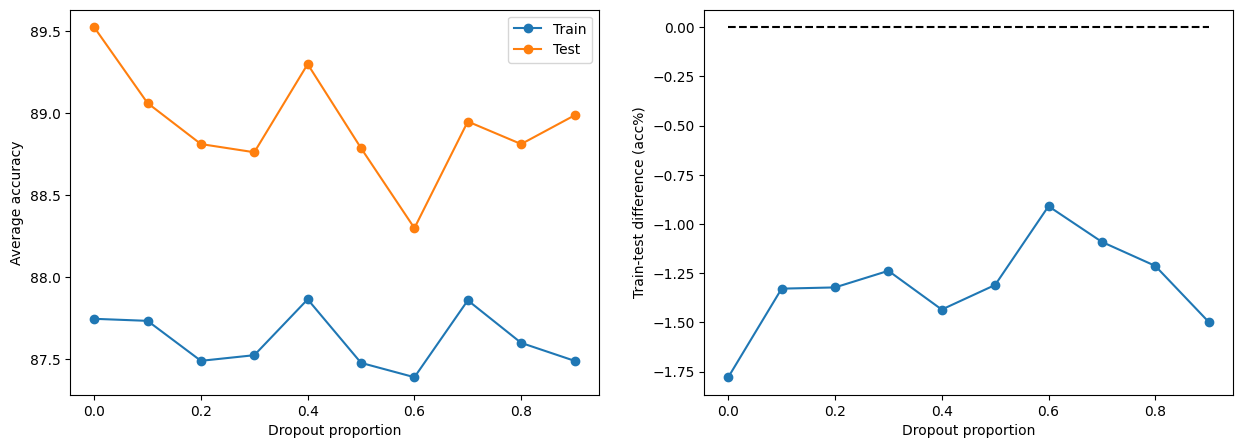

In [43]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()